In [1]:
import os
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Read in data

In [2]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "tutorial_performance_data")

In [3]:
df = pd.read_csv(os.path.join(data_dir, "all_data.csv"))
df["short_name"] = df["name"].apply(lambda x: x[:21])
df["memory_increase"] = df["max_mem"] - df["start_mem"]
df['datetime'] = pd.to_datetime(df["datetime"])

In [4]:
df['tmp'] = df.apply(lambda x: x["name"] if x.loc["ran_successfully"] else "", axis=1)
df['ran_successfully'].mean()

0.60625

In [5]:
df['name_if_ran'] = df.apply(lambda x: x.loc["name"] if x.loc["ran_successfully"] else "", axis=1)

# Identifies runs where the same set of tutorials completed
# Used to make sure we don't compare aggregated data from 
# runs where different tutorials were run
df["set_of_tutorials_run_hash"] = (
    df.groupby("fname")
    ["name_if_ran"]
    .transform(
        lambda x: hash(
            "".join(x.sort_values().values)
        )
    )
)
df.head()

name  ran_successfully    runtime  \
0  GIBBON_for_efficient_batch_entropy_search              True  17.157764   
1          Multi_objective_multi_fidelity_BO              True  42.191367   
2                batch_mode_cross_validation              True   3.063518   
3                          bo_with_warped_gp              True  11.943523   
4                                       bope             False        NaN   

    start_mem     max_mem        mode commit_hash                   datetime  \
0  114.222656  601.785156  smoke-test    68547512 2023-02-21 20:00:29.634413   
1  115.996094  597.347656  smoke-test    68547512 2023-02-21 20:00:29.634413   
2  116.746094  555.121094  smoke-test    68547512 2023-02-21 20:00:29.634413   
3  117.472656  570.277344  smoke-test    68547512 2023-02-21 20:00:29.634413   
4         NaN         NaN  smoke-test    68547512 2023-02-21 20:00:29.634413   

                                               fname             short_name  \
0  smoke-test_68547512_2023-02-21 20:00:29.634413...  GIBBON_for_efficient_   
1  smoke-test_68547512_2023-02-21 20:00:29.634413...  Multi_objective_multi   
2  smoke-test_68547512_2023-02-21 20:00:29.634413...  batch_mode_cross_vali   
3  smoke-test_68547512_2023-02-21 20:00:29.634413...      bo_with_warped_gp   
4  smoke-test_68547512_2023-02-21 20:00:29.634413...                   bope   

   memory_increase                                        tmp  \
0       487.562500  GIBBON_for_efficient_batch_entropy_search   
1       481.351562          Multi_objective_multi_fidelity_BO   
2       438.375000                batch_mode_cross_validation   
3       452.804688                          bo_with_warped_gp   
4              NaN                                              

                                 name_if_ran  set_of_tutorials_run_hash  
0  GIBBON_for_efficient_batch_entropy_search       -5330794966730054495  
1          Multi_objective_multi_fidelity_BO       -5330794966730054495  
2                batch_mode_cross_validation       -5330794966730054495  
3                          bo_with_warped_gp       -5330794966730054495  
4                                                  -5330794966730054495

# Plot performance metrics over time

In [6]:
per_hash_data = (
    df.groupby(["mode", "set_of_tutorials_run_hash"])
    .agg(
        n_runs = ("fname", lambda x: len(x.drop_duplicates())),
        most_recent_run = ("datetime", "max")
    )
    .reset_index()
)
# loosen this as more data comes in
per_hash_data["keep"] = (
    (per_hash_data["n_runs"] > 2) | (per_hash_data["most_recent_run"] > "2023-02-24")
)
per_hash_data

mode  set_of_tutorials_run_hash  n_runs            most_recent_run  \
0  smoke-test       -5330794966730054495       7 2023-02-24 19:58:07.215365   
1  smoke-test        6907884505623895760       2 2023-02-27 19:44:34.250401   
2    standard        4334608203797383931       5 2023-02-23 11:25:20.403119   
3    standard        5370717415316184279       4 2023-02-27 11:35:36.278266   
4    standard        6907884505623895760       2 2023-02-21 18:31:22.638945   

    keep  
0   True  
1   True  
2   True  
3   True  
4  False

In [7]:
hashes_to_plot = per_hash_data.loc[per_hash_data['keep'], ['mode', 'set_of_tutorials_run_hash']]
hashes_to_plot

mode  set_of_tutorials_run_hash
0  smoke-test       -5330794966730054495
1  smoke-test        6907884505623895760
2    standard        4334608203797383931
3    standard        5370717415316184279

In [8]:
time_series_data_wide = (
    df
    .merge(hashes_to_plot)
    .groupby("fname")
    .agg(
        mode=("mode", "first"),
        set_of_tutorials_run_hash=("set_of_tutorials_run_hash", "first"),
        datetime=("datetime", "first"),
        total_runtime=("runtime", "sum"),
        slowest_runtime=("runtime", "max"),
        avg_memory=("memory_increase", "mean"),
        max_memory=("memory_increase", "max")
    )
)

time_series_data_wide.head()

mode  \
fname                                                            
smoke-test_52959e64_2023-02-22 21:46:29.434078.csv  smoke-test   
smoke-test_587885de_2023-02-24 19:58:07.215365.csv  smoke-test   
smoke-test_5df2fab1_2023-02-23 20:21:36.360977.csv  smoke-test   
smoke-test_68547512_2023-02-21 20:00:29.634413.csv  smoke-test   
smoke-test_7e9fb1b8_2023-02-24 03:57:39.084018.csv  smoke-test   

                                                    set_of_tutorials_run_hash  \
fname                                                                           
smoke-test_52959e64_2023-02-22 21:46:29.434078.csv       -5330794966730054495   
smoke-test_587885de_2023-02-24 19:58:07.215365.csv       -5330794966730054495   
smoke-test_5df2fab1_2023-02-23 20:21:36.360977.csv       -5330794966730054495   
smoke-test_68547512_2023-02-21 20:00:29.634413.csv       -5330794966730054495   
smoke-test_7e9fb1b8_2023-02-24 03:57:39.084018.csv       -5330794966730054495   

                                                                     datetime  \
fname                                                                           
smoke-test_52959e64_2023-02-22 21:46:29.434078.csv 2023-02-22 21:46:29.434078   
smoke-test_587885de_2023-02-24 19:58:07.215365.csv 2023-02-24 19:58:07.215365   
smoke-test_5df2fab1_2023-02-23 20:21:36.360977.csv 2023-02-23 20:21:36.360977   
smoke-test_68547512_2023-02-21 20:00:29.634413.csv 2023-02-21 20:00:29.634413   
smoke-test_7e9fb1b8_2023-02-24 03:57:39.084018.csv 2023-02-24 03:57:39.084018   

                                                    total_runtime  \
fname                                                               
smoke-test_52959e64_2023-02-22 21:46:29.434078.csv    1290.205423   
smoke-test_587885de_2023-02-24 19:58:07.215365.csv     658.961862   
smoke-test_5df2fab1_2023-02-23 20:21:36.360977.csv     671.019105   
smoke-test_68547512_2023-02-21 20:00:29.634413.csv     658.368388   
smoke-test_7e9fb1b8_2023-02-24 03:57:39.084018.csv     696.757290   

                                                    slowest_runtime  \
fname                                                                 
smoke-test_52959e64_2023-02-22 21:46:29.434078.csv       294.099438   
smoke-test_587885de_2023-02-24 19:58:07.215365.csv       183.547607   
smoke-test_5df2fab1_2023-02-23 20:21:36.360977.csv       187.566077   
smoke-test_68547512_2023-02-21 20:00:29.634413.csv       166.174323   
smoke-test_7e9fb1b8_2023-02-24 03:57:39.084018.csv       198.477094   

                                                    avg_memory   max_memory  
fname                                                                        
smoke-test_52959e64_2023-02-22 21:46:29.434078.csv  614.819261  1663.875000  
smoke-test_587885de_2023-02-24 19:58:07.215365.csv  595.049429  1622.644531  
smoke-test_5df2fab1_2023-02-23 20:21:36.360977.csv  598.450421  1641.160156  
smoke-test_68547512_2023-02-21 20:00:29.634413.csv  615.532001  1584.796875  
smoke-test_7e9fb1b8_2023-02-24 03:57:39.084018.csv  594.579477  1602.078125

In [9]:
time_series_data_long = (
    pd.melt(
        time_series_data_wide,#.reset_index(),
        id_vars=[
            #"fname",
            "mode", "set_of_tutorials_run_hash", "datetime"],
        value_vars=["total_runtime", "slowest_runtime", "avg_memory", "max_memory"],
        var_name="metric"
    )
)
time_series_data_long.dtypes

mode                                 object
set_of_tutorials_run_hash             int64
datetime                     datetime64[ns]
metric                               object
value                               float64
dtype: object

In [10]:
def make_time_series_plot(time_series_data_long: pd.DataFrame, mode: str) -> sns.FacetGrid:
    keep_data = time_series_data_long[
       # time_series_data_long["keep"] & 
        (time_series_data_long["mode"] == mode)
    ].sort_values("datetime")
    if len(keep_data) == 0:
        print(f"No {mode} data.")
        return
    g = sns.FacetGrid(
        data=keep_data,
        col="metric",
        col_wrap=2,
        aspect=1.5,
        sharey=False,
        hue="set_of_tutorials_run_hash",
        palette="viridis"
    )
    g.map(plt.plot, "datetime", "value")
    g.map(plt.scatter, "datetime", "value")
    g.add_legend()
    g.fig.suptitle(mode)
    plt.subplots_adjust(top=0.9)
    for ax in g.axes.flatten():
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    return g

In [11]:
def make_histogram(time_series_data_long: pd.DataFrame, mode: str) -> sns.FacetGrid:
    if not (per_hash_data["mode"] == mode).any():
        print(f"No relevant {mode} data.")
        return
    most_recent_hash = (
        per_hash_data[per_hash_data["mode"] == mode]
        .sort_values("most_recent_run")
        ["set_of_tutorials_run_hash"]
        .values[-1]
    )
    
    keep_data = time_series_data_long[
       # time_series_data_long["keep"] & 
        (time_series_data_long["mode"] == mode)
        & (time_series_data_long["set_of_tutorials_run_hash"] == most_recent_hash)
    ]
    if len(keep_data) == 0:
        print(f"No relevant {mode} data.")
        return
    g = sns.FacetGrid(
        data=keep_data,
        col="metric",
        col_wrap=2,
        aspect=1.5,
        sharex=False
    )
    g.map(plt.hist, "value", color='k')
    g.fig.suptitle(mode)
    plt.subplots_adjust(top=0.9)
    return g

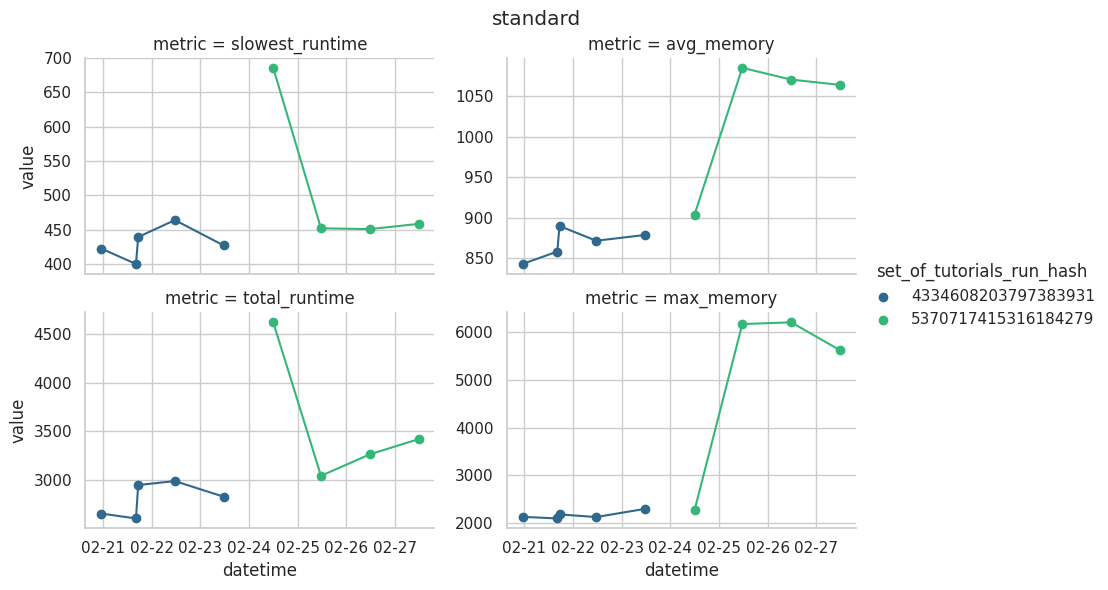

In [12]:
make_time_series_plot(time_series_data_long, "standard")

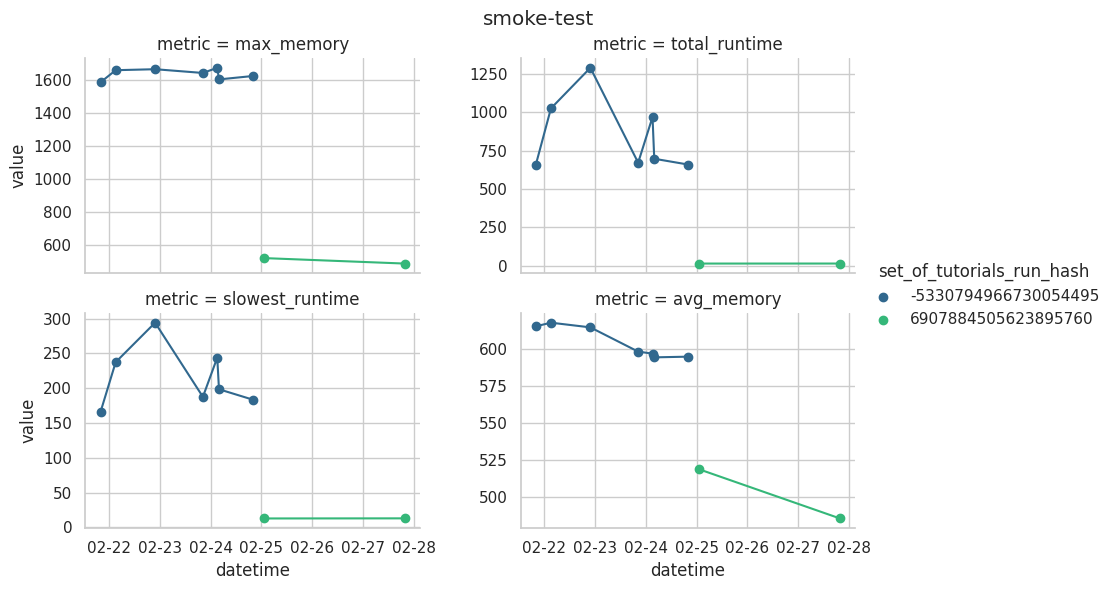

In [13]:
make_time_series_plot(time_series_data_long, "smoke-test")

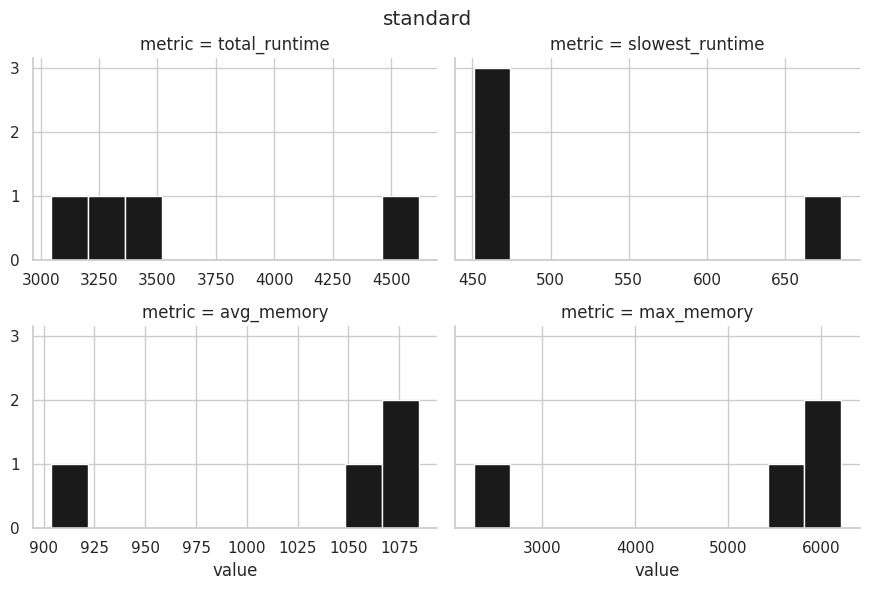

In [14]:
make_histogram(time_series_data_long, "standard")

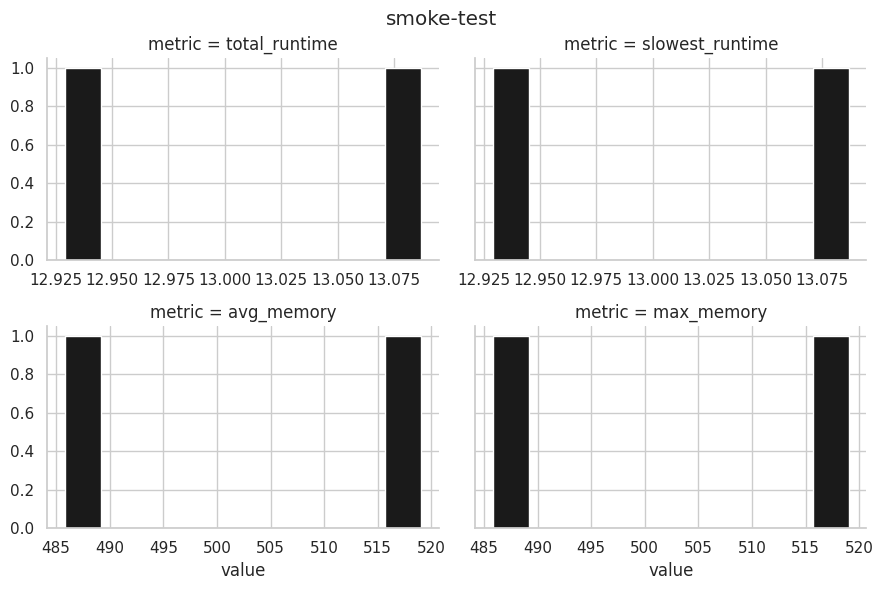

In [15]:
make_histogram(time_series_data_long, "smoke-test")

# Per-tutorial time series plots and histograms

In [16]:
# time series, one tutorial at a time
def make_per_tutorial_ts_plot(mode: str):
    idx = df["ran_successfully"] & (df["mode"] == mode)
    if not idx.any():
        print(f"No data for {mode}")
        return
    g = sns.FacetGrid(
        data=pd.melt(
            df[idx],
            id_vars=["short_name", "datetime"],
            value_vars=["runtime", "memory_increase"],
            value_name="value",
            var_name="metric"
        ),
        col="metric",
        row="short_name",
        sharey=False,
        aspect=3
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.map(plt.plot, "datetime", "value", color="k")
    g.map(plt.scatter, "datetime", "value", color="k")

In [17]:
def make_per_tutorial_hist(mode: str):
    idx = df["ran_successfully"] & (df["mode"] == mode)
    if not idx.any():
        print(f"No data for {mode}")
        return
    g = sns.FacetGrid(
        data=pd.melt(
            df[idx],
            id_vars=["short_name", "datetime"],
            value_vars=["runtime", "memory_increase"],
            value_name="value",
            var_name="metric"
        ),
        col="metric",
        row="short_name",
        sharex=False,
        aspect=3
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.map(plt.hist, "value", color="k")

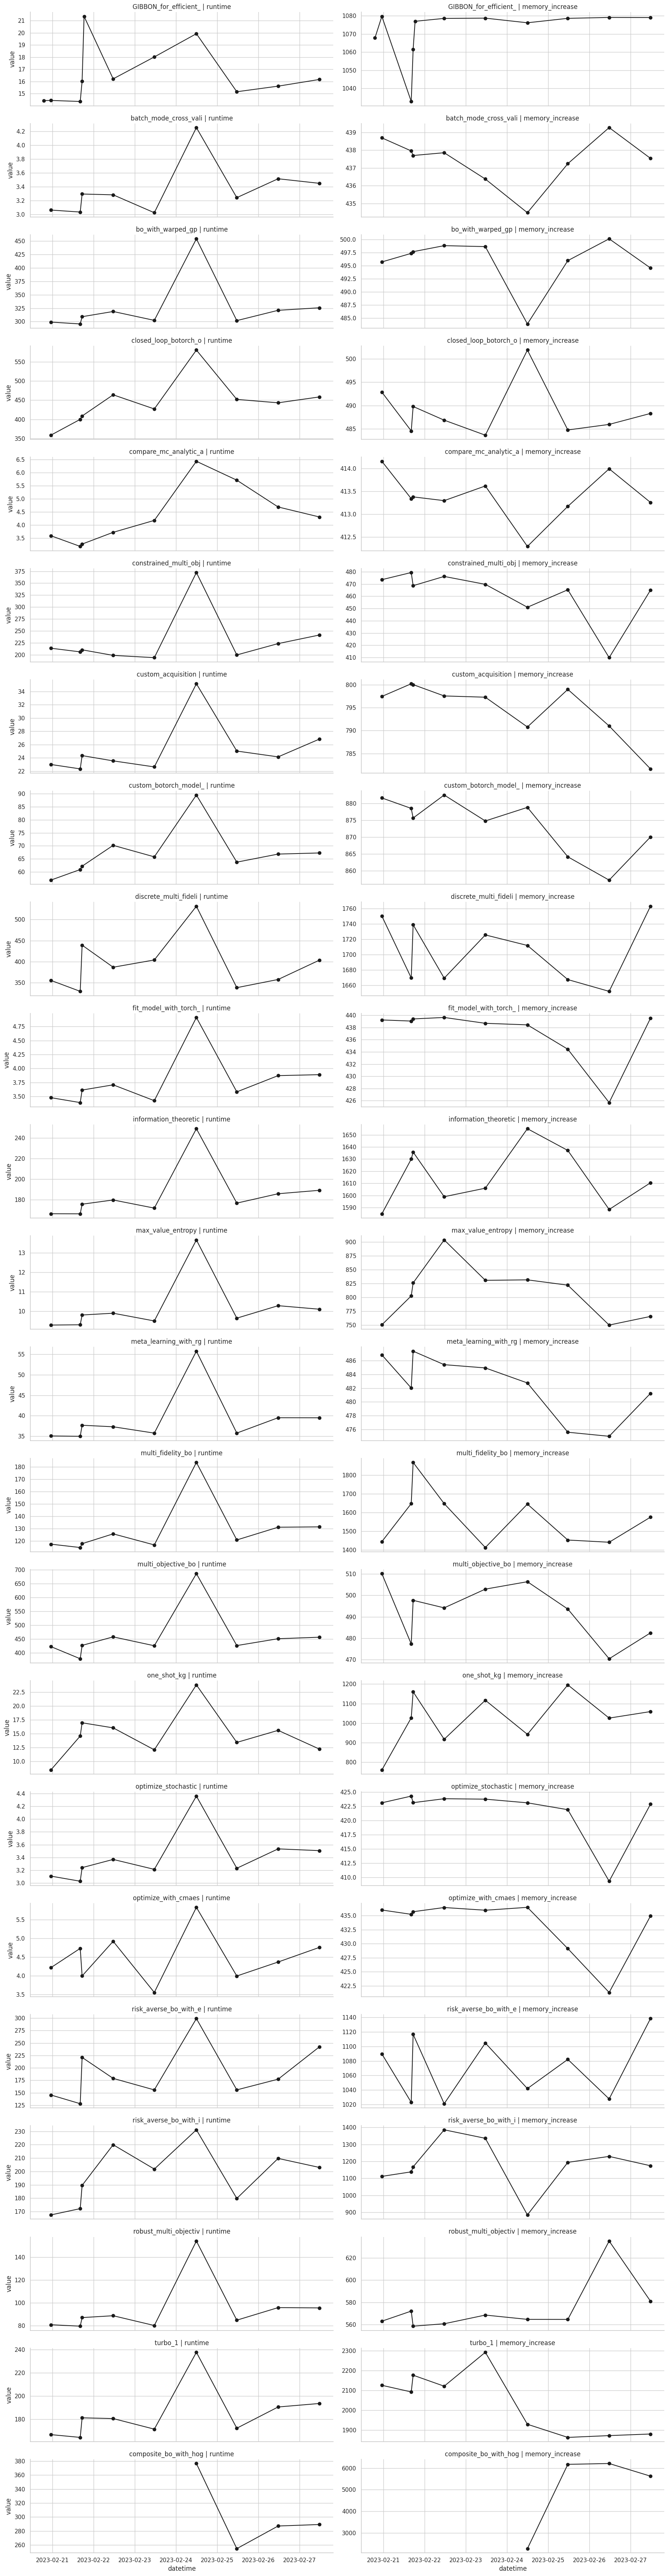

In [18]:
make_per_tutorial_ts_plot("standard")

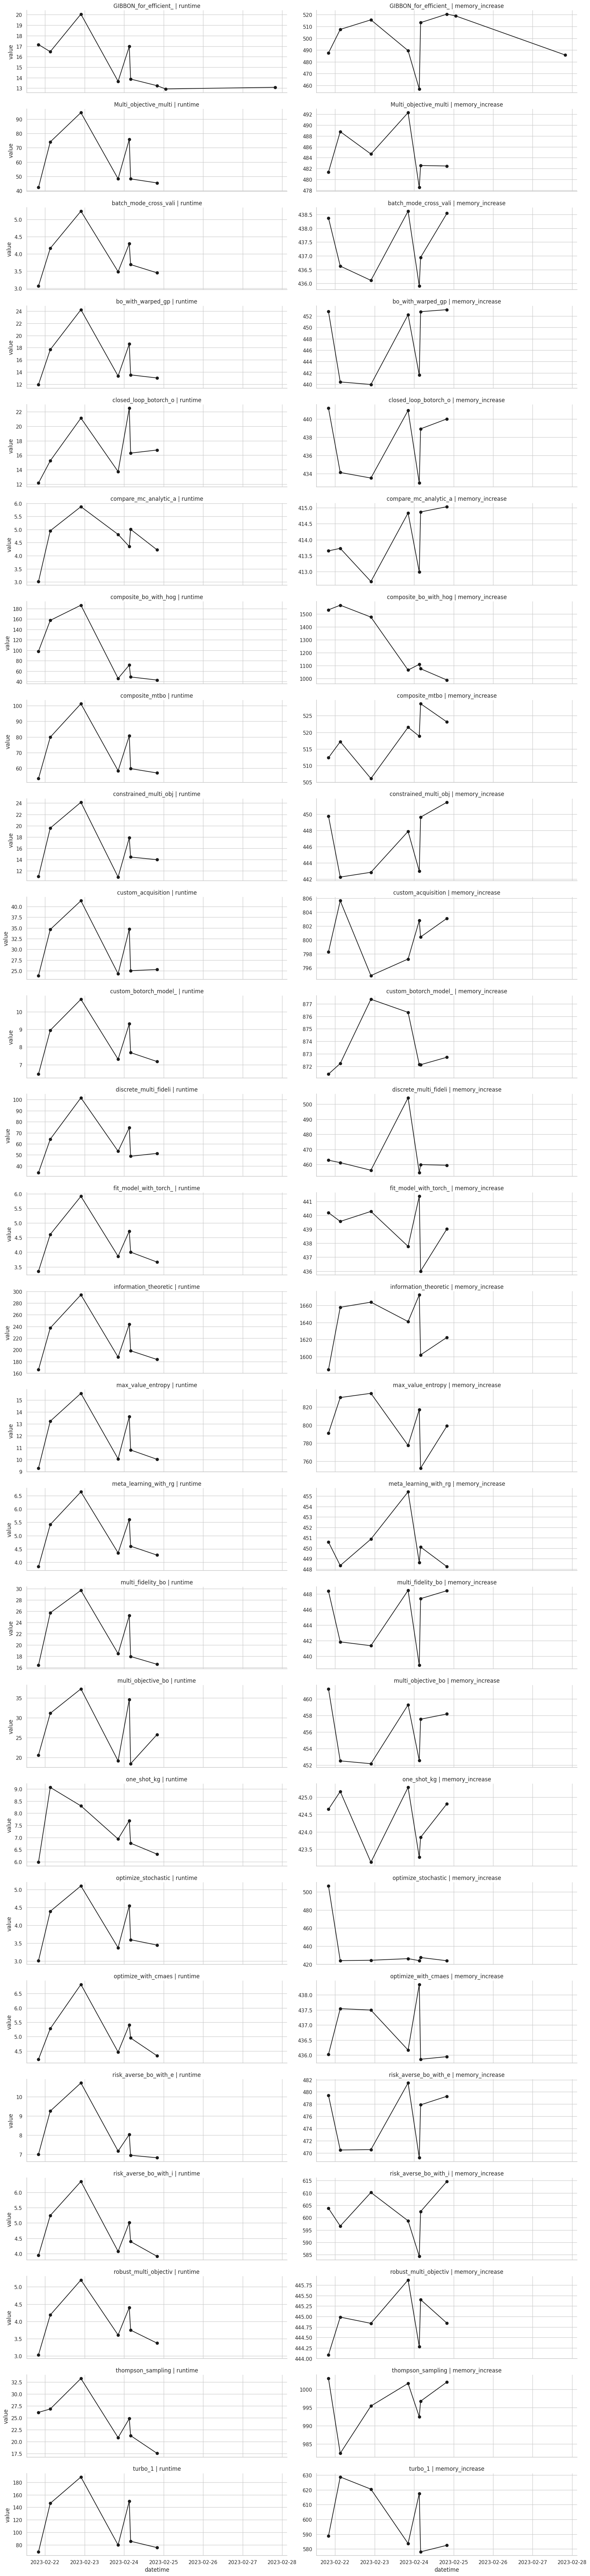

In [19]:
make_per_tutorial_ts_plot("smoke-test")

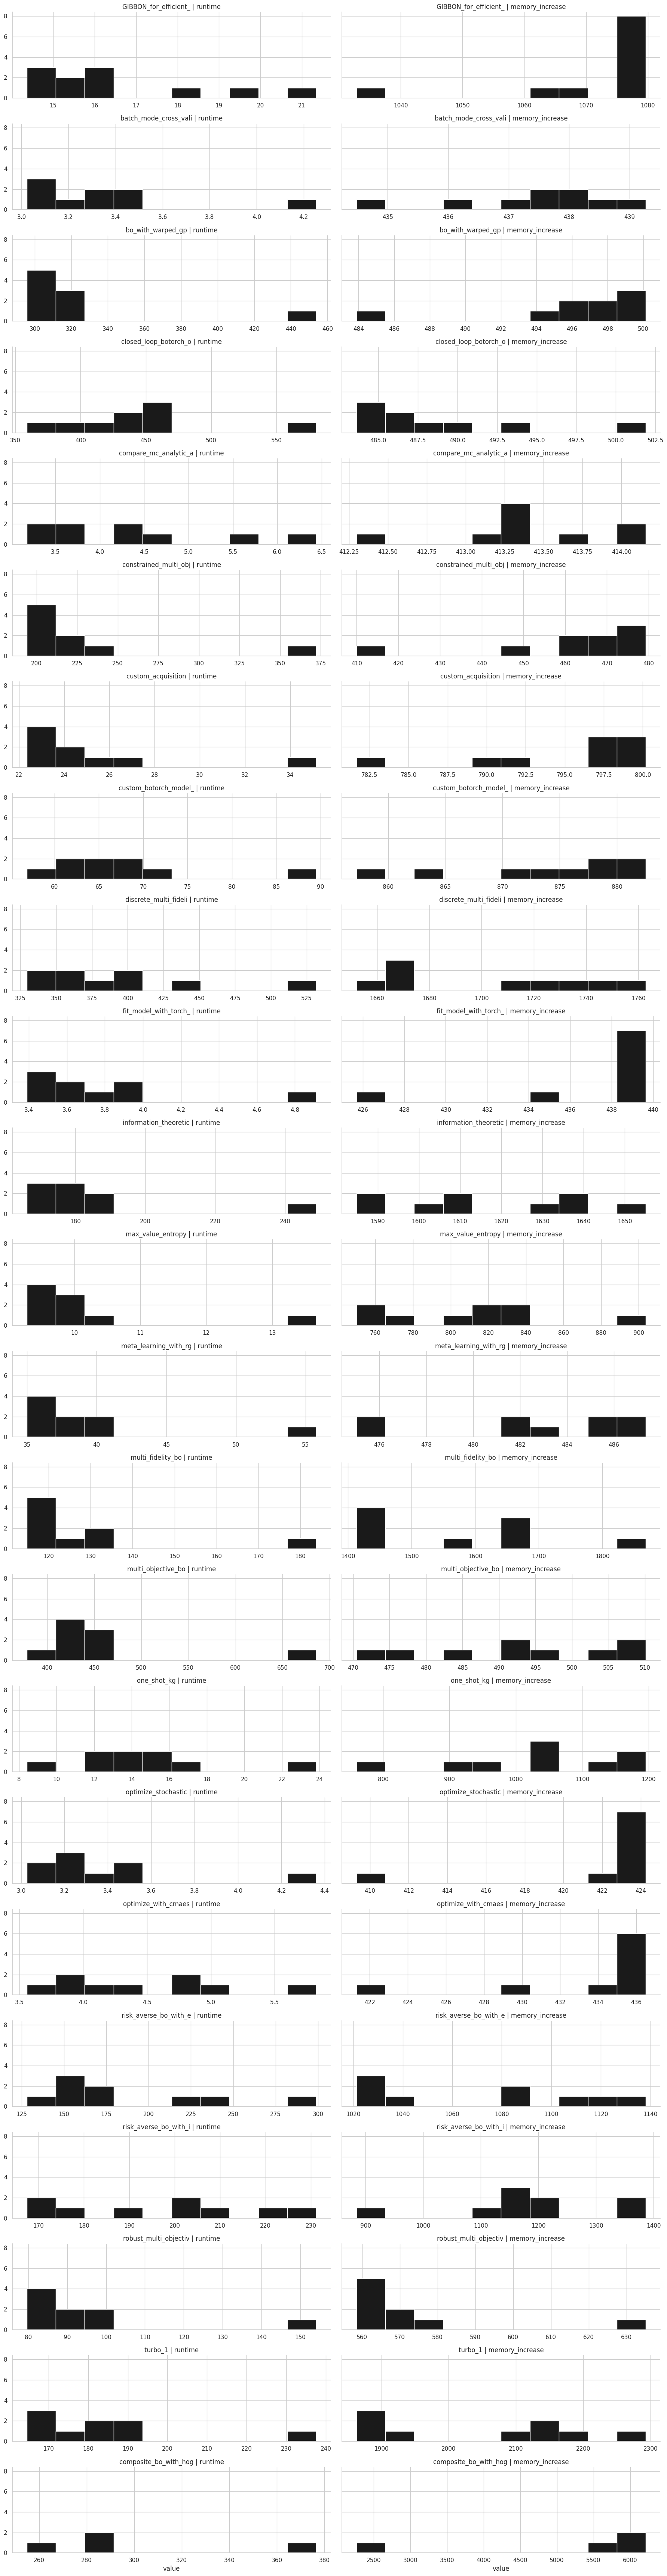

In [20]:
make_per_tutorial_hist("standard")

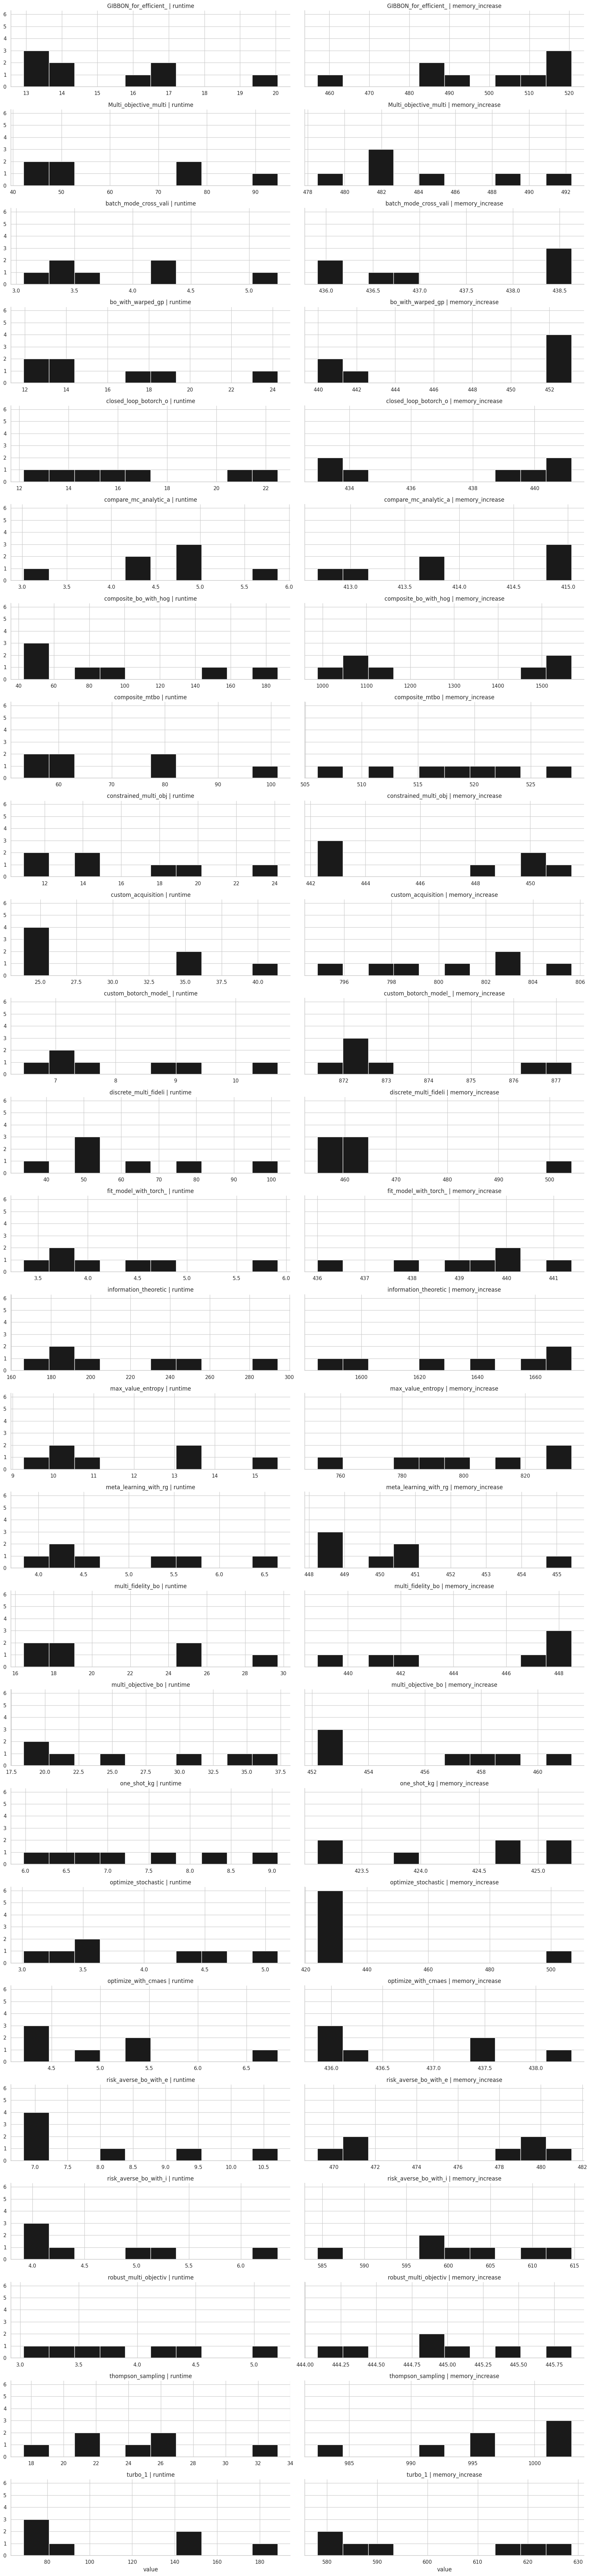

In [21]:
make_per_tutorial_hist("smoke-test")

# Compare tutorials against each other

In [22]:
last_run_data = df[
    df["datetime"] == df.groupby("mode")["datetime"].transform("max")
].sort_values("memory_increase")
last_run_data_long = pd.melt(
    last_run_data, id_vars=["mode", "name"], value_vars=["runtime", "memory_increase"],
    var_name="metric"
)
last_run_data_long.head()

mode                             name   metric     value
0  standard  compare_mc_analytic_acquisition  runtime  4.305478
1  standard              optimize_stochastic  runtime  3.506045
2  standard              optimize_with_cmaes  runtime  4.759608
3  standard      batch_mode_cross_validation  runtime  3.447465
4  standard   fit_model_with_torch_optimizer  runtime  3.888761

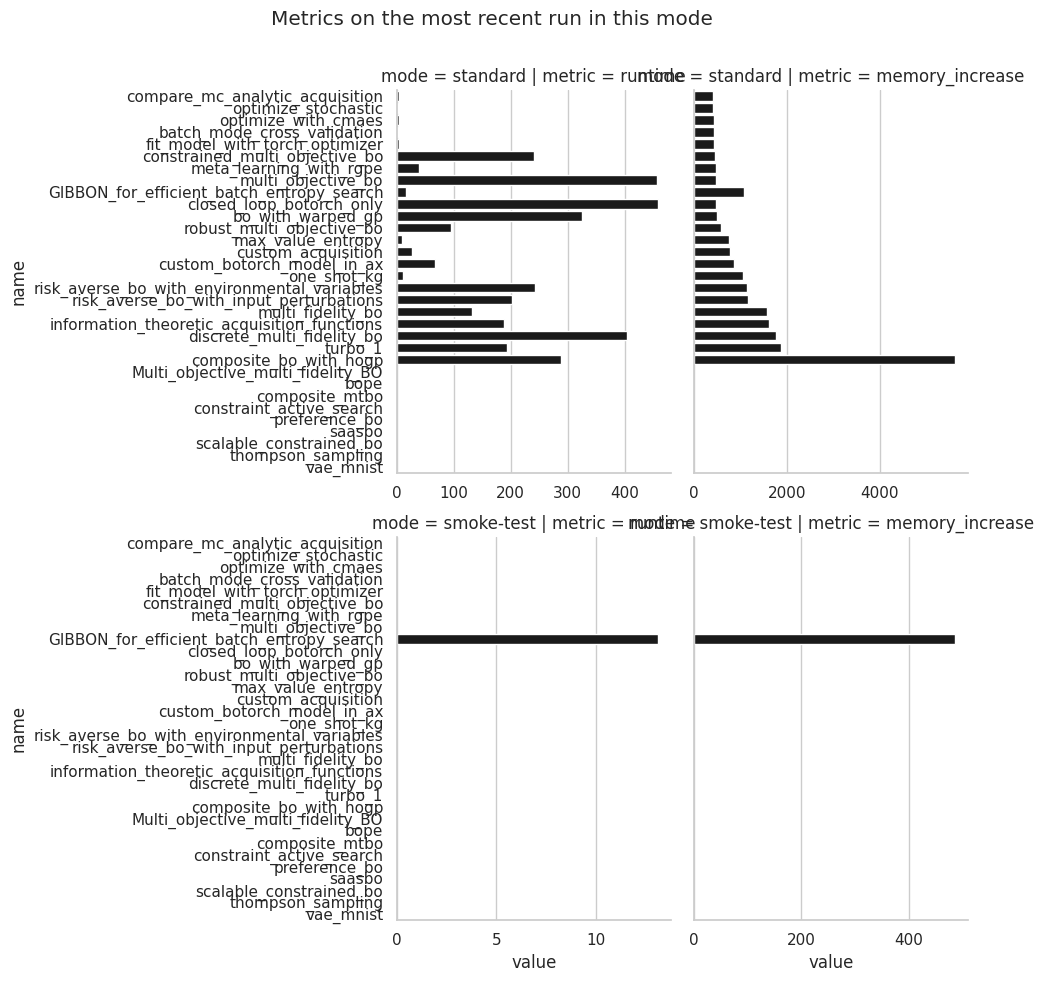

In [23]:
g = sns.catplot(
    data=last_run_data_long,
    col="metric",
    row="mode",
    x="value",
    y="name",
    kind="bar",
    orient="h",
    sharex=False,
    color="k"
)
g.fig.suptitle("Metrics on the most recent run in this mode")
plt.subplots_adjust(top=0.9)